In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Simple RNN


## weather dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = '../output'
modelDir = '../models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
tf.random.set_seed(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read FIFA 2019 data set

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
data_df.shape

(96453, 12)

In [6]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## take care of time zone

In [7]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


##  Visualization

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [10]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [11]:
num_col = ['Temperature (C)','Apparent Temperature (C)', 'Humidity','Wind Speed (km/h)',
           'Wind Bearing (degrees)','Visibility (km)','Loud Cover','Pressure (millibars)']

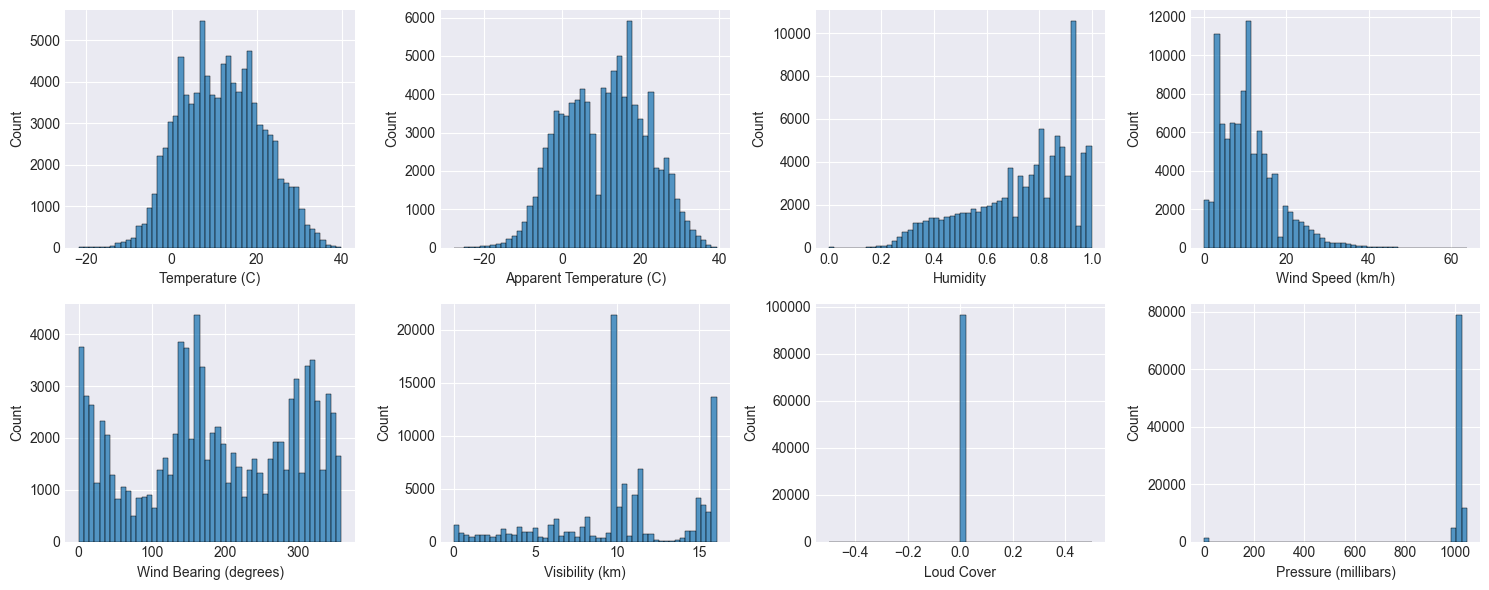

In [12]:
fig,axes = plt.subplots(2,4)
axes = axes.ravel()
for count, col in enumerate(num_col):
    ax = axes[count]
    sns.histplot(data_df, x=col, ax=ax, bins=50)
plt.tight_layout()

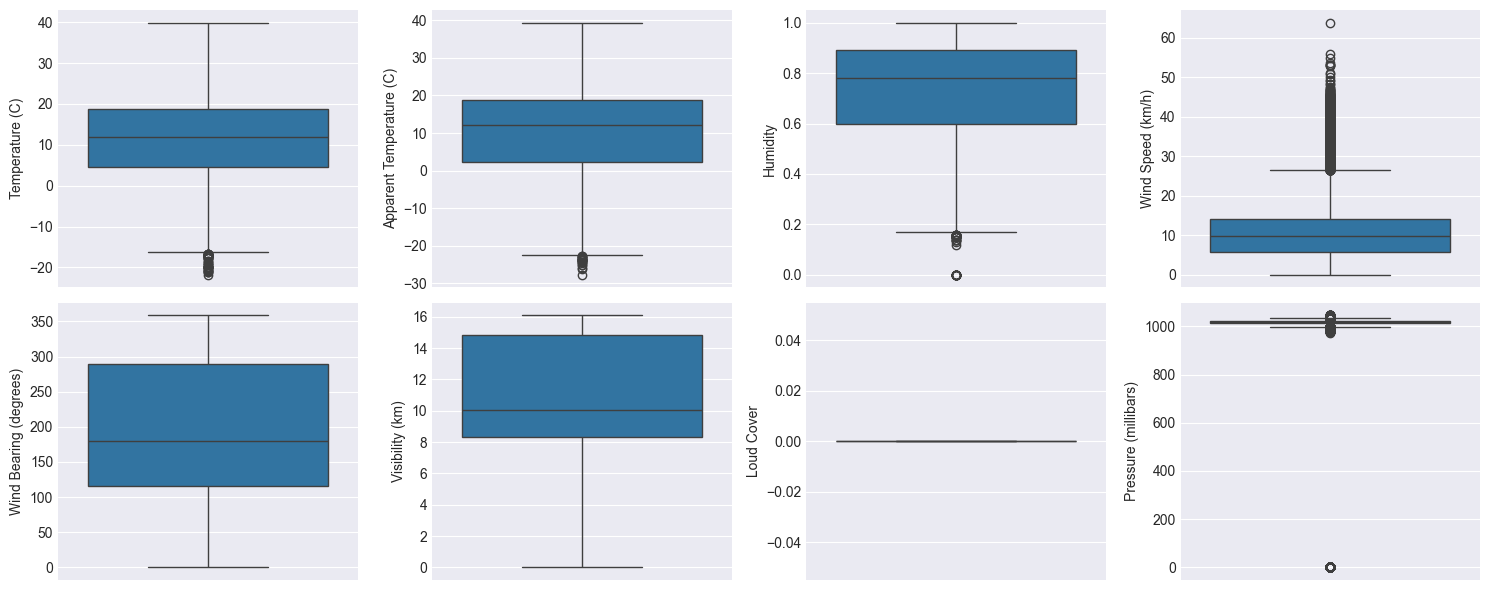

In [13]:
fig,axes = plt.subplots(2,4)
axes = axes.ravel()
for count, col in enumerate(num_col):
    ax = axes[count]
    sns.boxplot(data_df, y=col, ax=ax)
plt.tight_layout()

In [14]:
data_df[num_col].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


<Axes: >

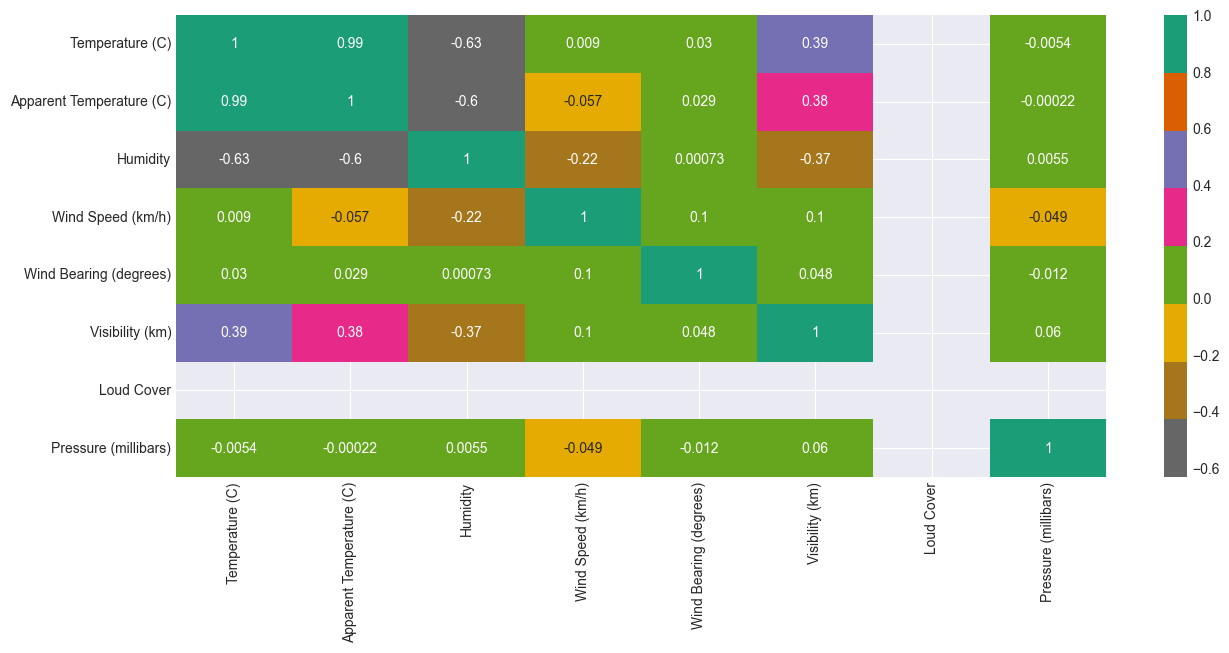

In [15]:
sns.heatmap(data_df[num_col].corr(), annot=True, cmap='Dark2_r')

In [16]:
tmp_df = data_df[['datetime','Temperature (C)',
                  'Humidity', 'Visibility (km)']]
tmp_df = tmp_df.sort_values('datetime', axis=0, ascending=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.head()

,datetime,Temperature (C),Humidity,Visibility (km)
0,2005-12-31 23:00:00+00:00,0.577778,0.89,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,9.9015


In [18]:
tmp_df = tmp_df.rename({'Temperature (C)':'temp','Humidity':'hum','Visibility (km)':'viz'},axis=1)
tmp_df.head()

,datetime,temp,hum,viz
0,2005-12-31 23:00:00+00:00,0.577778,0.89,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,9.9015


<Axes: xlabel='datetime'>

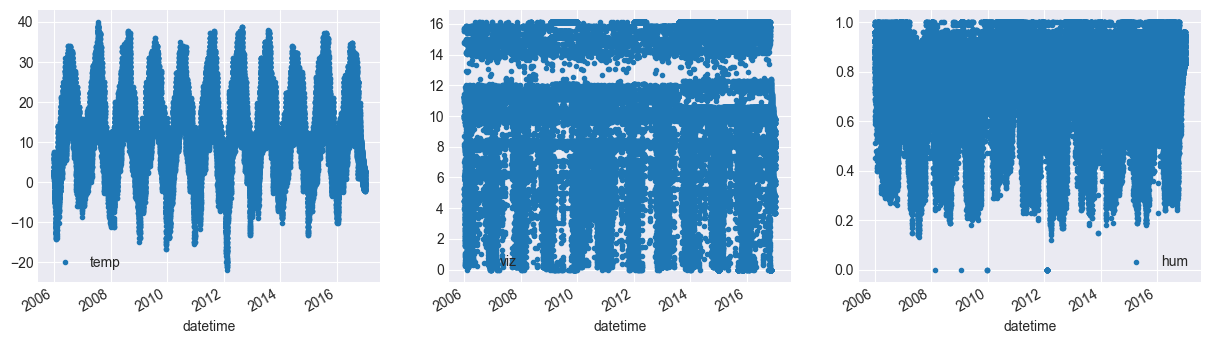

In [20]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,3,1)
tmp_df.plot(x= 'datetime', y='temp', style='.',ax = ax)
ax = fig.add_subplot(1,3,2)
tmp_df.plot(x= 'datetime', y='viz', style='.',ax = ax)
ax = fig.add_subplot(1,3,3)
tmp_df.plot(x= 'datetime', y='hum', style='.',ax = ax)

## Data preparations

### 

In [25]:
time_step = 24
y_index = np.arange(time_step,tmp_df.shape[0], time_step)
y_index

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [27]:
y_df = tmp_df.iloc[y_index][['datetime','temp']]

X_df =tmp_df.iloc[range(len(y_df)*time_step)]  ### only taking data as training data where len/time step is whole 
                                                ### number insuring every data in X_df has ouyput y_df
    
    
X_temp = np.reshape(X_df['temp'].to_numpy(),
              (y_df.shape[0],time_step))

X_hum = np.reshape(X_df['hum'].to_numpy(),
              (y_df.shape[0],time_step))

X_viz = np.reshape(X_df['viz'].to_numpy(),
              (y_df.shape[0],time_step))

X_temp = X_temp[:,:23]
X_hum = X_hum[:,:23]
X_viz = X_viz[:,:23]

X_viz.shape

(4018, 23)

In [29]:
X_data = np.stack((X_temp,X_hum), axis=2)
X_data.shape

(4018, 23, 2)

In [31]:
# splitting in train ans test datasets
split = int(y_df.shape[0]*(1-TEST_SIZE))

X_train = X_data[:split]
X_test = X_data[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

## Model

In [32]:
h_units=256
input_shape=(time_step-1,X_train.shape[2])

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units= h_units, 
                                    input_shape=input_shape,
                                    activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(loss = 'mean_squared_error',optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [33]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

wax, waa, baa, way, bay

((2, 256), (256, 256), (256,), (256, 1), (1,))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66304     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66561 (260.00 KB)
Trainable params: 66561 (260.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history = model.fit(X_train,y_train, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/20

101/101 [==============================] - 4s 22ms/step - loss: 10.9695 - root_mean_squared_error: 3.3120 - val_loss: 1.0059 - val_root_mean_squared_error: 1.0030
Epoch 2/20
101/101 [==============================] - 2s 18ms/step - loss: 1.6917 - root_mean_squared_error: 1.3006 - val_loss: 0.8645 - val_root_mean_squared_error: 0.9298
Epoch 3/20
101/101 [==============================] - 2s 18ms/step - loss: 1.3149 - root_mean_squared_error: 1.1467 - val_loss: 0.8203 - val_root_mean_squared_error: 0.9057
Epoch 4/20
101/101 [==============================] - 2s 19ms/step - loss: 1.1947 - root_mean_squared_error: 1.0930 - val_loss: 0.8023 - val_root_mean_squared_error: 0.8957
Epoch 5/20
101/101 [==============================] - 2s 18ms/step - loss: 1.1075 - root_mean_squared_error: 1.0524 - val_loss: 0.7086 - val_root_mean_squared_error: 0.8418
Epoch 6/20
101/101 [==============================] - 2s 18ms/step - loss: 1.1306 - root_mean_squared_error: 1.0633 - val_loss: 0.885

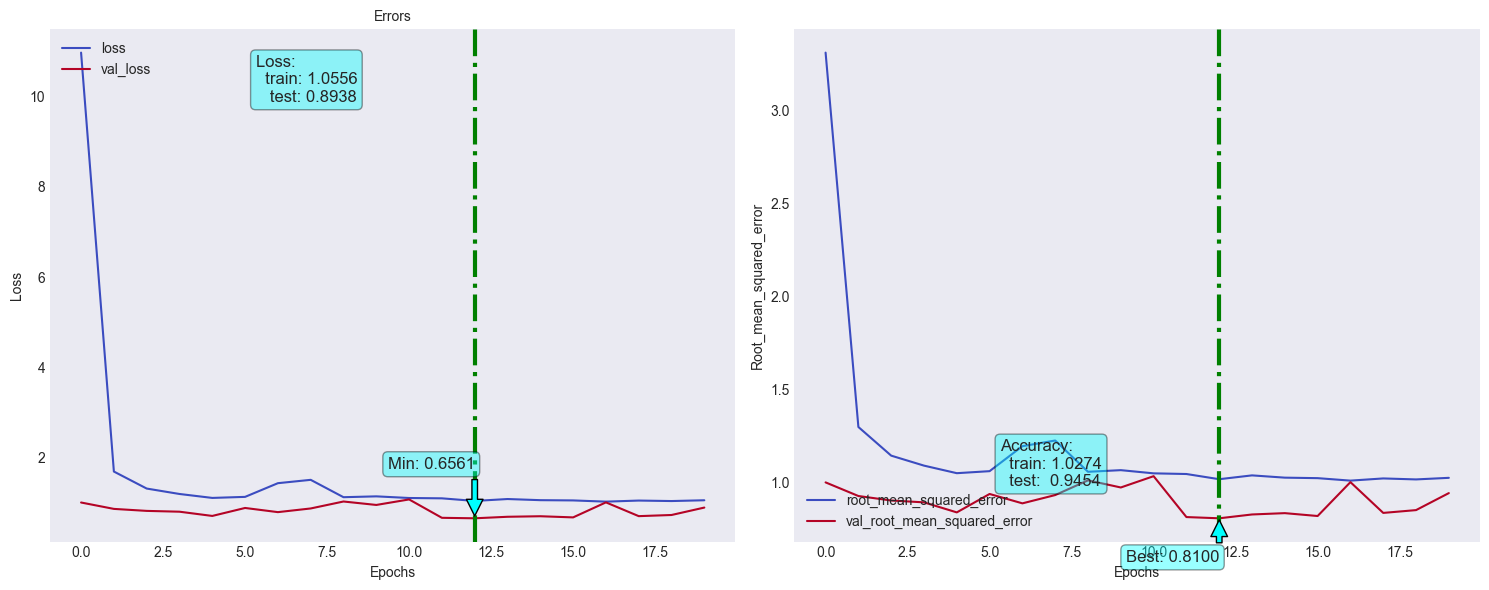

In [36]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [62]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred,y_test_pred)
y_pred

26/26 [==============================] - 0s 8ms/step


array([ 4.3794637,  1.3238238,  1.4381093, ..., -1.0339798, -1.0817816,
       -1.1239159], dtype=float32)

In [63]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.379464
48,2006-01-02,1.694444,1.323824
72,2006-01-03,2.200000,1.438109
96,2006-01-04,1.666667,1.351177
120,2006-01-05,1.805556,1.881807


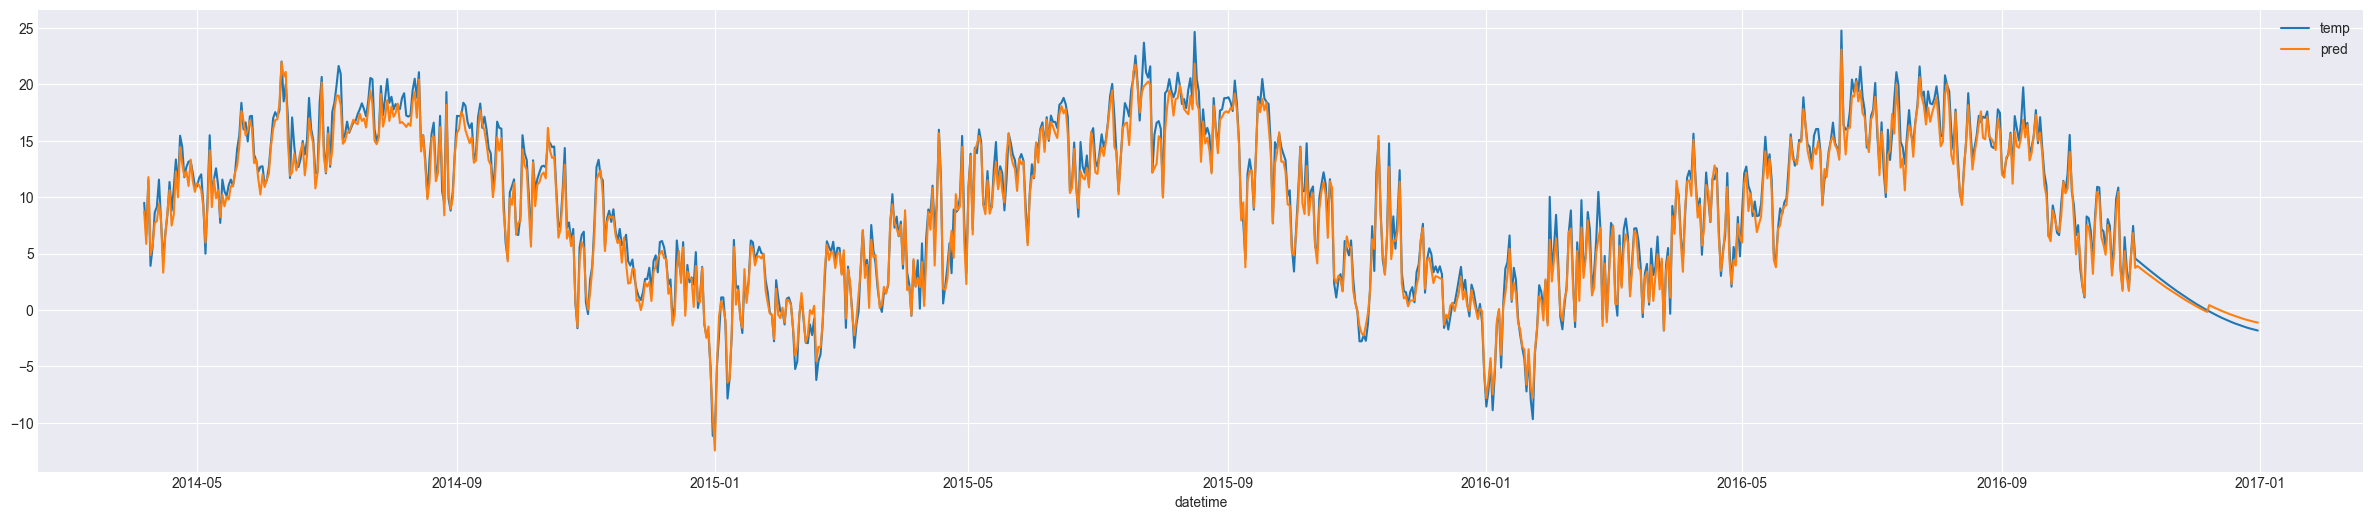

In [67]:
fig, ax = plt.subplots(figsize=(30,6))
res_df[-1000:].plot(x = 'datetime', y= ['temp', 'pred'], ax=ax);